<a href="https://colab.research.google.com/github/EngIyasu/Flood_Mapping_using_Google_Earth_Engine_and_SAR_Data/blob/master/Flood_Mapping_using_Google_Earth_Engine_and_SAR_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Google Earth Engine (GEE) and Synthetic Aperture Radar (SAR) Data for Flood Mapping in Nile Basin

This notebook presents the detection of flooded area over Khartoum, Sudan and its surrounding region from the overflow of Nile Rivers and heavy rains by utilizing Sentinel-1 synthetic aperture radar (SAR) data acquired during dry and wet seasons of 2020. According to the [International Federation of Red Cross and Red Crescent Societies's (IFRC) ](https://www.ifrc.org/en/news-and-media/news-stories/africa/sudan/heavy-rains-and-flash-floods-in-sudan-66633/) report, the heavy rains (from middle July to August) and overflow of Nile Rivers (both Blue and White) have caused flooding, destruction of infrastructure, houses and livelihoods, and have displaced thousands of people in multiple locations across the country, primiarly in Khartoum and its surrounding area. 

<div align="center">
  <img width="800" height="500" src="https://www.dabangasudan.org/uploads/cache/article_detail_image/uploads/media/5f589cb1db2d9.png">
</div>

## Authenticate to Colab and Cloud

In [1]:
from google.colab import auth
auth.authenticate_user()

### Authenticate to Earth Engine

In [1]:
import ee
ee.Authenticate()
ee.Initialize()

### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Test the Folium installation

We will use the Folium library for visualization.  Import the library and check the version.

In [4]:
import folium
print(folium.__version__)

0.8.3


In [5]:
## Define Region of Interest (ROI)
roi_sudan_flood = ee.Geometry.Polygon(
          [[[31.41530839413144, 16.337129261064035],
          [31.41530839413144, 13.679202933707627],
          [34.26626054256894, 13.679202933707627],
          [34.26626054256894, 16.337129261064035]]])

## Load Sentinel-1 C-band SAR Ground Range collection (log scale, VV, descending)
collectionVV = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filter(ee.Filter.eq('instrumentMode', 'IW'))\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
.filterMetadata('resolution_meters', 'equals' , 10)\
.filterBounds(roi_sudan_flood)\
.select('VV') 

## Load Sentinel-1 C-band SAR Ground Range collection (log scale, VH, descending) 
collectionVH = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filter(ee.Filter.eq('instrumentMode', 'IW'))\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
.filterMetadata('resolution_meters', 'equals' , 10)\
.filterBounds(roi_sudan_flood)\
.select('VH')

## Filter by season
wet2020VV = collectionVV.filterDate('2020-08-25', '2020-09-02').mosaic()
dry2020VV = collectionVV.filterDate('2020-03-01', '2020-03-31').mosaic()
wet2020VH = collectionVH.filterDate('2020-08-25', '2020-09-02').mosaic()
dry2020VH = collectionVH.filterDate('2020-03-01', '2020-03-31').mosaic()

In [6]:
## Use folium to visualize the imagery.

mapidVVwet = wet2020VV.getMapId({'min': -15, 'max': 0})
mapidVVdry = dry2020VV.getMapId({'min': -15, 'max': 0})
mapidVHwet = wet2020VH.getMapId({'min': -25, 'max': 0})
mapidVHdry = dry2020VH.getMapId({'min': -25, 'max': 0})

map = folium.Map(location=[15.5288,32.5402],zoom_start=8)
folium.TileLayer(
    tiles=mapidVVwet['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Wet2020VV',
  ).add_to(map)
folium.TileLayer(
    tiles=mapidVVdry['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Det2020VV',
  ).add_to(map)
folium.TileLayer(
    tiles=mapidVHwet['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Wet2020VH',
  ).add_to(map)
folium.TileLayer(
    tiles=mapidVHdry['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Det2020VH',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [7]:
## Apply filter to reduce speckle
SMOOTHING_RADIUS = 50;
wet2020VV_filtered = wet2020VV.focal_mean(SMOOTHING_RADIUS, 'circle', 'meters')
dry2020VV_filtered = dry2020VV.focal_mean(SMOOTHING_RADIUS, 'circle', 'meters')
wet2020VH_filtered = wet2020VH.focal_mean(SMOOTHING_RADIUS, 'circle', 'meters')
dry2020VH_filtered = dry2020VH.focal_mean(SMOOTHING_RADIUS, 'circle', 'meters')

### Comparing speckle filtered and unfiltered images

In [8]:
mapidVVwet_fil = wet2020VV_filtered.getMapId({'min': -15, 'max': 0})
mapidVVdry_fil = dry2020VV_filtered.getMapId({'min': -15, 'max': 0})
mapidVHwet_fil = wet2020VH_filtered.getMapId({'min': -25, 'max': 0})
mapidVHdry_fil = dry2020VH_filtered.getMapId({'min': -25, 'max': 0})

mapcom = folium.Map(location=[15.5288,32.5402],zoom_start=8)
folium.TileLayer(
    tiles=mapidVVwet_fil['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Wet2020VV Filtered',
  ).add_to(mapcom)
folium.TileLayer(
    tiles=mapidVVdry_fil['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Det2020VV Filtered',
  ).add_to(mapcom)
folium.TileLayer(
    tiles=mapidVHwet_fil['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Wet2020VH Filtered',
  ).add_to(mapcom)
folium.TileLayer(
    tiles=mapidVHdry_fil['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Det2020VH Filtered',
  ).add_to(mapcom)
mapcom.add_child(folium.LayerControl())
mapcom

In [9]:
## Calculate difference between wet (flooded) and dry seasons
differenceVH = wet2020VH_filtered.divide(dry2020VH_filtered)
differenceVV = wet2020VV_filtered.divide(dry2020VV_filtered)

## Apply Threshold   
DIFF_UPPER_THRESHOLD = 1.25;
differenceVH_thresholded = differenceVH.gt(DIFF_UPPER_THRESHOLD);
differenceVV_thresholded = differenceVV.gt(DIFF_UPPER_THRESHOLD);

In [10]:
vv_masked = differenceVV_thresholded.updateMask(differenceVV_thresholded)
vh_masked = differenceVH_thresholded.updateMask(differenceVH_thresholded)

mapid_vv  = vv_masked.getMapId({'palette': ['red']})
mapid_vh  = vh_masked.getMapId({'palette': ['red']})

map1 = folium.Map(location=[15.5288,32.5402],zoom_start=11)
folium.TileLayer(
    tiles=mapid_vv['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='flooded areas VV - Red',
  ).add_to(map1)
folium.TileLayer(
    tiles=mapid_vh['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='flooded areas VH - Red',
  ).add_to(map1)
map1.add_child(folium.LayerControl())
map1

In [11]:
## Saving map
map1.save('./gdrive/My Drive/Sudan_Flooding/Flooded_Area_Sudan_Summer_2020.html')

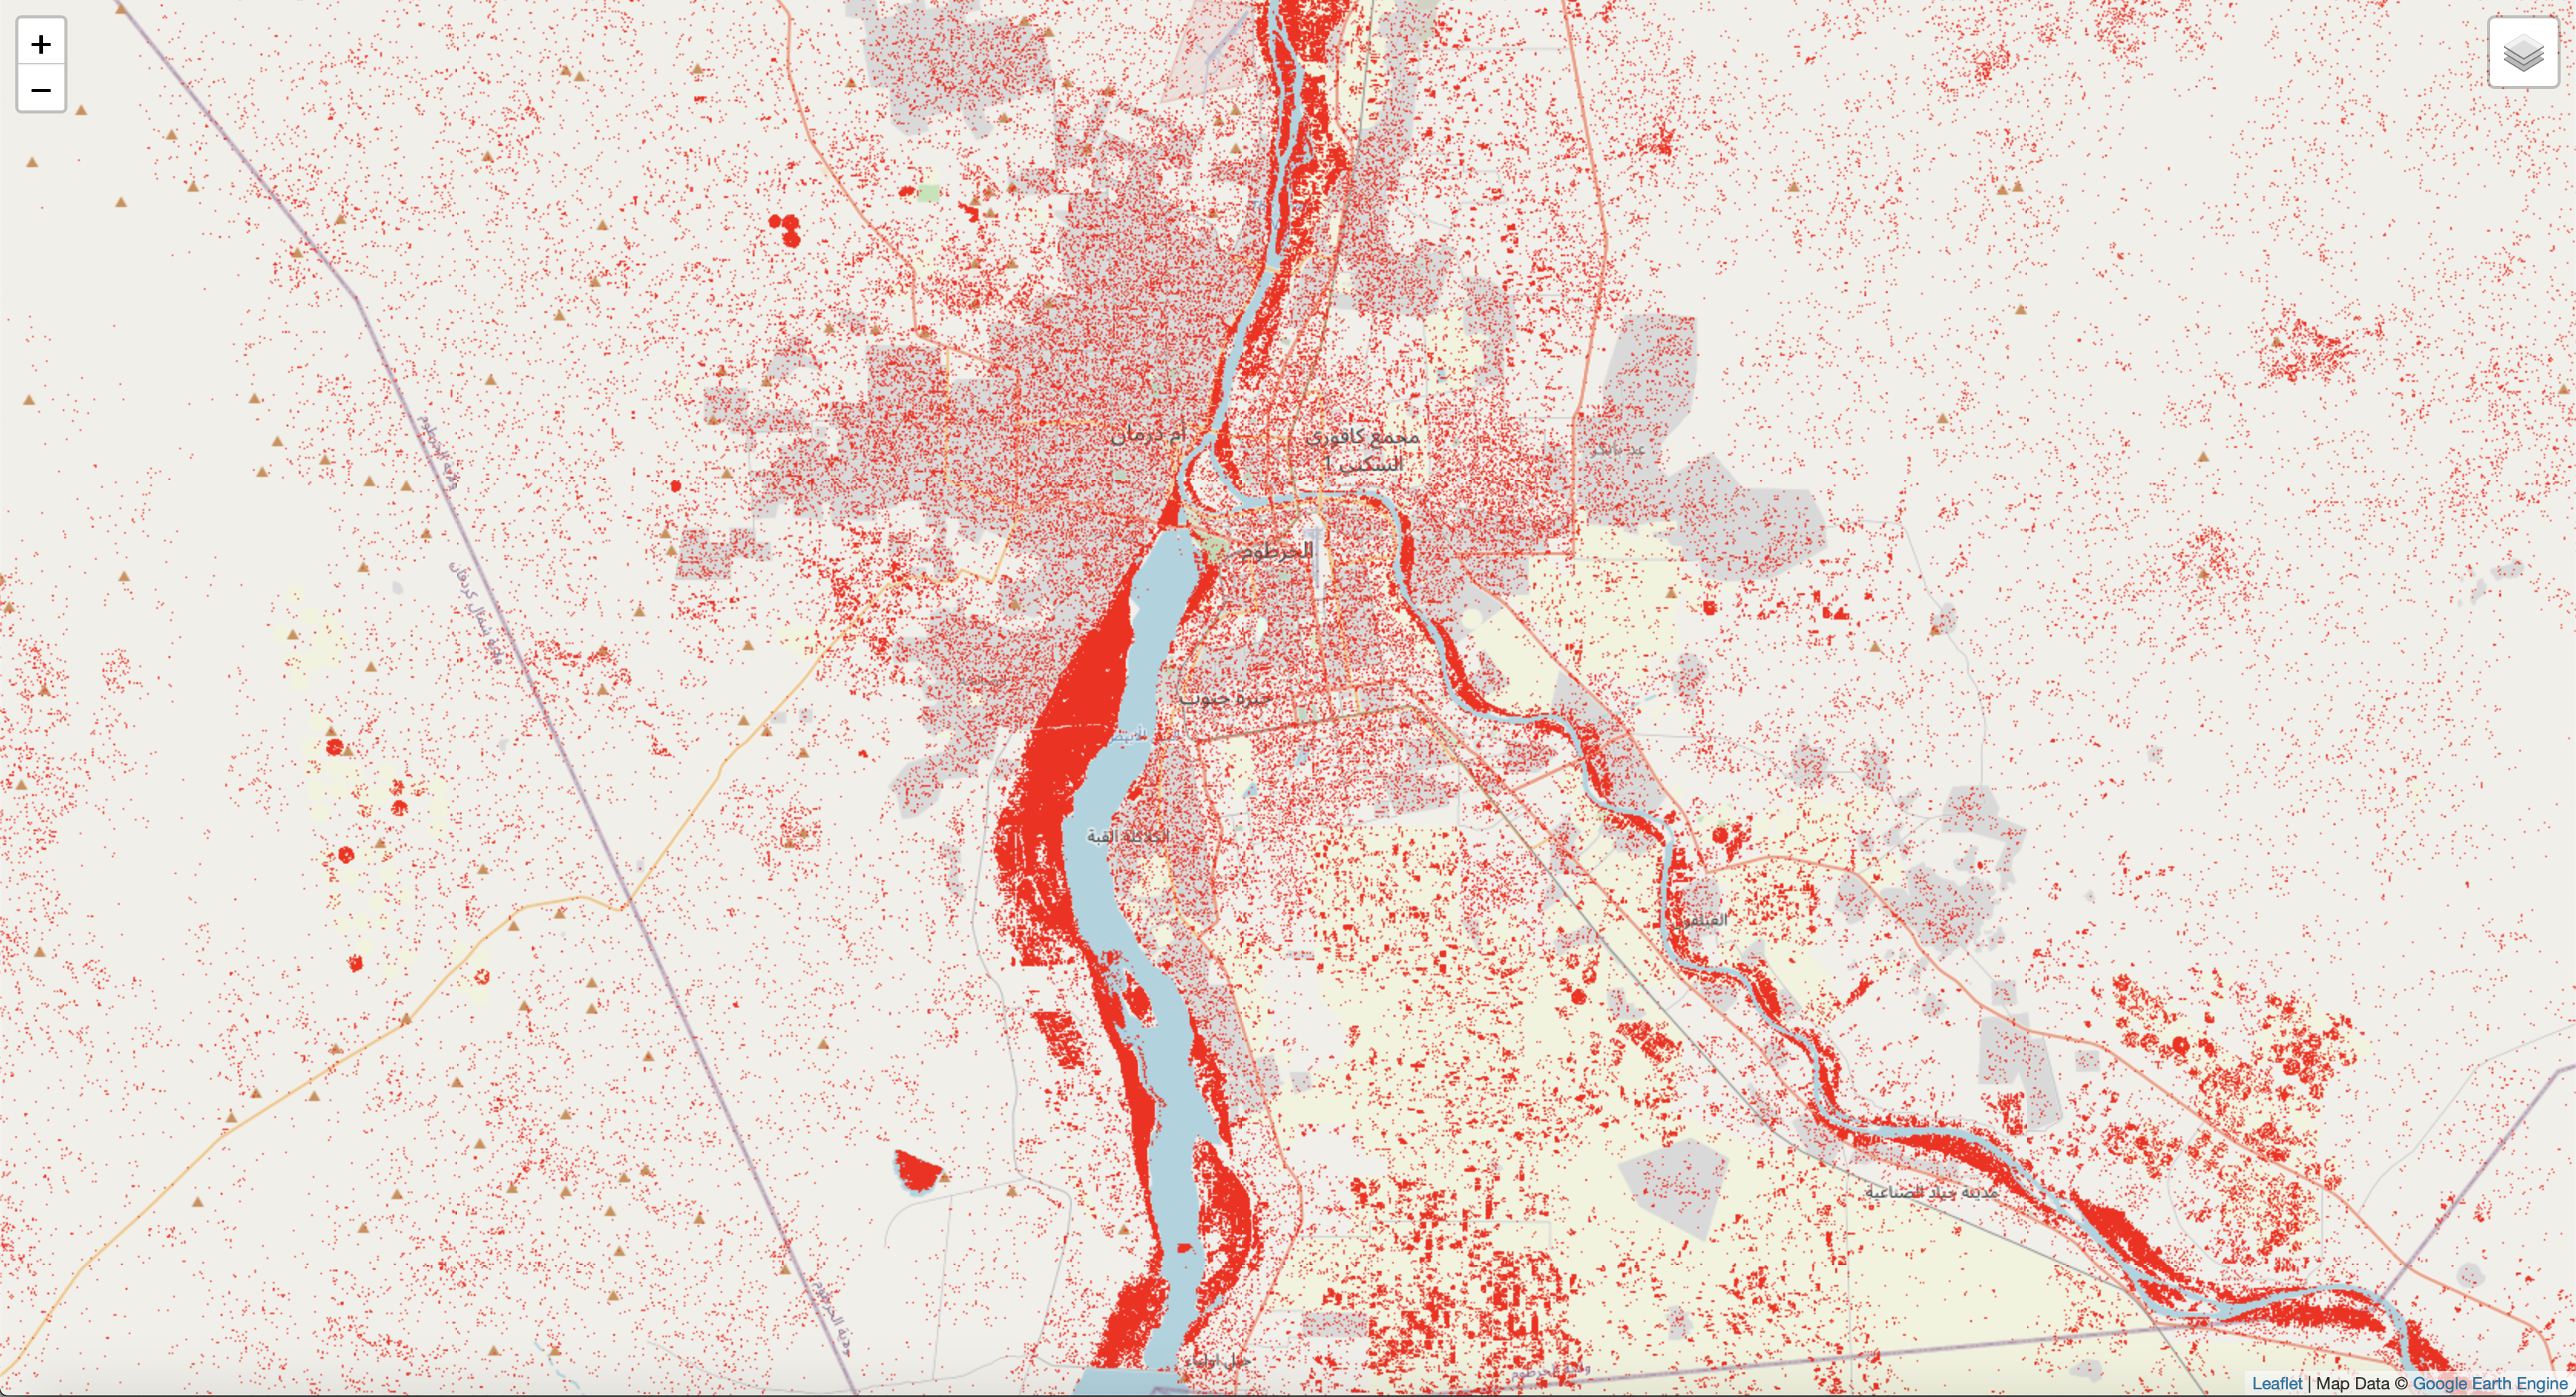

In [12]:
## Displaying the PNG Image
from IPython.display import display, Image
Image('./gdrive/My Drive/Sudan_Flooding/Flooded_Area_Sudan_Summer_2020_VV.png', width=1200)